# Clean light curves

### Open raw FITS files from MAST, clean out `nan`s

Save copies to `raw_long`, `raw_short` directories. 

In [1]:
#%load_ext autoreload
#%autoreload 2

import os
from glob import glob
import datacleaner
reload(datacleaner)
from datacleaner import LightCurve
import numpy as np

path_to_fits_files = '/local/tmp/hat11/010748390/'

# Retrieve long and short cadence data
long_cadence_paths = glob(os.path.join(path_to_fits_files, '*llc.fits'))
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

long_lc = LightCurve.from_raw_fits(long_cadence_paths, name='raw_long')
short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short')

data_path = '/astro/users/bmmorris/git/hat-11/data'
long_lc.save_to(data_path)
short_lc.save_to(data_path)

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


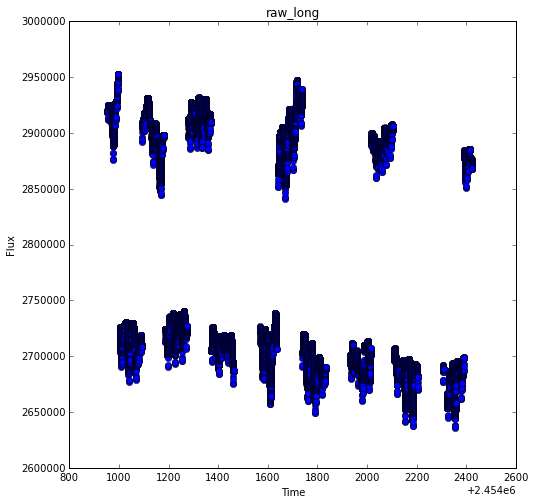

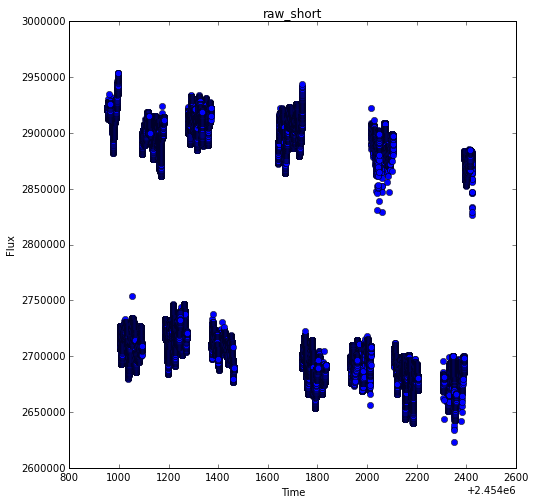

In [2]:
%matplotlib inline
long_lc.plot()
short_lc.plot()

### Normalize by quarter

For each quarter, fit a $O$(2) polynomial and divide the light curve by that polynomial. Save to `normalized_long` and `normalized_short`

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2

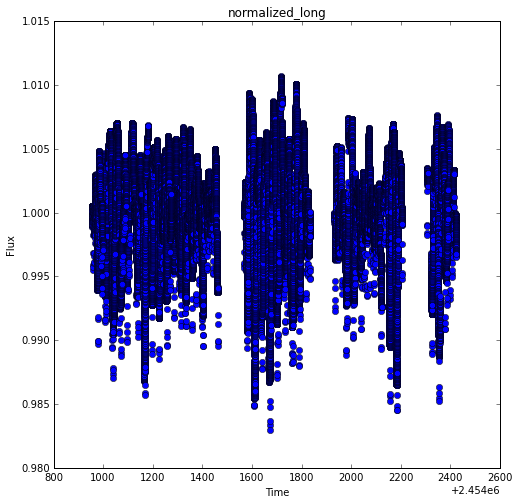

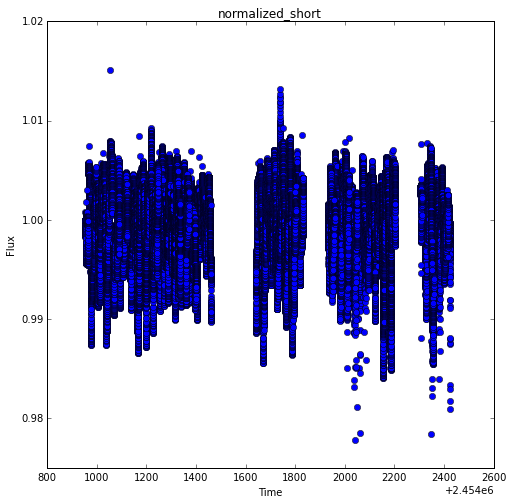

In [3]:
# Fit 2nd order polynomial to each quarter, divide to normalize
long_lc.normalize_each_quarter(rename='normalized_long')
short_lc.normalize_each_quarter(rename='normalized_short')

# Plot results, save
long_lc.plot()
short_lc.plot()

long_lc.save_to(data_path)
short_lc.save_to(data_path)

### Break out individual transits

Separate light curve into individual transits by masking out the out-of-transit portions of the light curve and separating the big `LightCurve` object into lots of little `TransitLightCurve` objects.

Then fit the out-of-transit portions of each transti for a linear baseline trend, and divide it out.

In [4]:
reload(datacleaner)
from datacleaner import LightCurve
short_transits = LightCurve(name='transits_short', **short_lc.mask_out_of_transit())
transits = short_transits.get_transit_light_curves()
for transit in transits:
    transit.remove_linear_baseline()

In [5]:
# Plot, save all transits after normalization
# [transit.plot(show=False, save_path='tmp/{}.png'.format(transit.name)) for transit in transits]

### Identify "spotless" transits

* do rough model fit to each transit, including only a few transit parameters ($R_p/R_s$, $a/R_s$, $i$, $t_0$)
* Measure $\chi^2$ for best-fit model

In [6]:
# Warning: this step fits each transit in the short cadence data and is slow (~2 min)
import os
chi2_file_path = 'chi2.npy'
if not os.path.exists(chi2_file_path):
    chi2 = np.array([transit.fiducial_transit_fit()[1] for transit in transits])
    np.save(chi2_file_path, chi2)
else:
    chi2 = np.load(chi2_file_path)

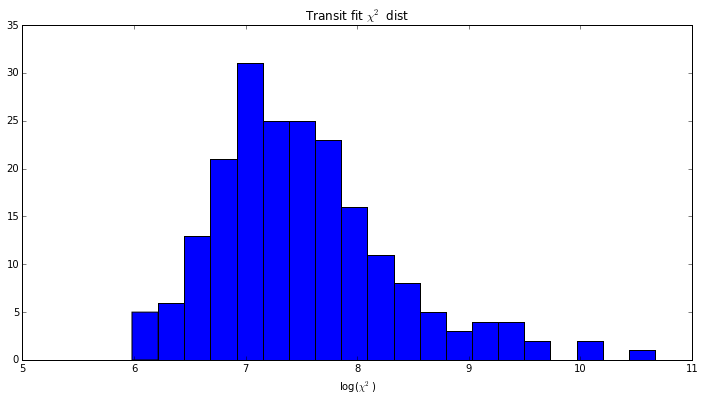

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()

The distribution of $\chi^2$ shows that there's a long tail of poor fits to the data, and a handful of very good fits. The handful of very good fits all have $\log{\chi^2} < 6.5$. Any higher than 6.5 and there are "visible" spots in the transit. Now filter out only these transits with $\log{\chi^2} < 6.5$ for detailed transit analysis.

### Combine "spotless" light curves, fit model

In [8]:
chi2 = []
depths = []
for transit in transits:
    p, chi = transit.fiducial_transit_fit()
    depths.append(p[1])
    chi2.append(chi)

# spotless transits: 3


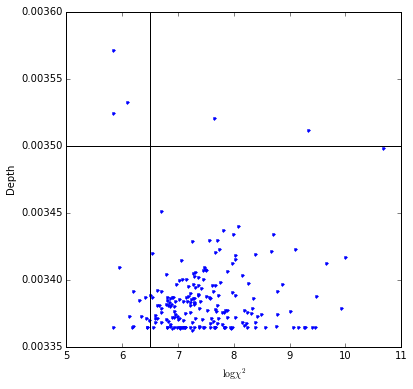

In [9]:
chi2_threshold = 6.5
depth_threshold = 0.0035
from datacleaner import combine_light_curves
spotless_transit_inds = (np.log(chi2) < chi2_threshold) * (np.array(depths) > depth_threshold)
spotless_transits = combine_light_curves([transit for i, transit in enumerate(transits) 
                                          if spotless_transit_inds[i]], name='spotless_transits')
spotless_transits.save_to(data_path)

print('# spotless transits: {}'.format(np.count_nonzero(spotless_transit_inds)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.log(chi2), depths, '.')
ax.axvline(chi2_threshold, color='k')
ax.axhline(depth_threshold, color='k')
ax.set(xlabel=r'$\log{\chi^2}$', ylabel=r'Depth');

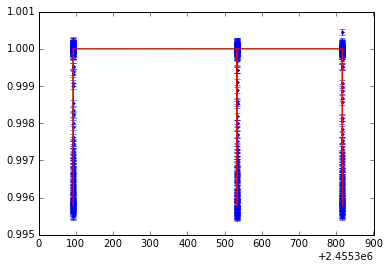

In [10]:
leastsq_fit_params, chi2_spotless = spotless_transits.fiducial_transit_fit(plots=True)

In [11]:
# reload(datacleaner)
# from datacleaner import combine_light_curves

# threshold_range = [6.2, 6.3, 6.4, 6.5]#np.linspace(6.2, 7.2, 3)
# leastsq_params = np.zeros((len(threshold_range), 4))

# for j, threshold in enumerate(threshold_range):
#     t = combine_light_curves([transit for i, transit in enumerate(transits) 
#                                               if np.log(chi2[i]) < threshold], name='low_chi2_transits')
#     leastsq_fit_params = t.fiducial_transit_fit(plots=False)[0]
#     leastsq_params[j, :] = leastsq_fit_params

In [12]:
# plt.plot(leastsq_params[:,1]);

In [13]:
# len([transit for i, transit in enumerate(transits) if np.log(chi2[i]) < 6.2])

### Use `emcee` to get PDFs for interesting transit parameters



In [19]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
[t0, depth, a, inc] = leastsq_fit_params
p0 = leastsq_fit_params
n_steps = 1000
scale_the_errors_by_a_factor_of = 1.1
transit_lc = spotless_transits
samples, sampler = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                             scale_the_errors_by_a_factor_of*transit_lc.errors, 
                             n_steps)

accept frac = 0.47745


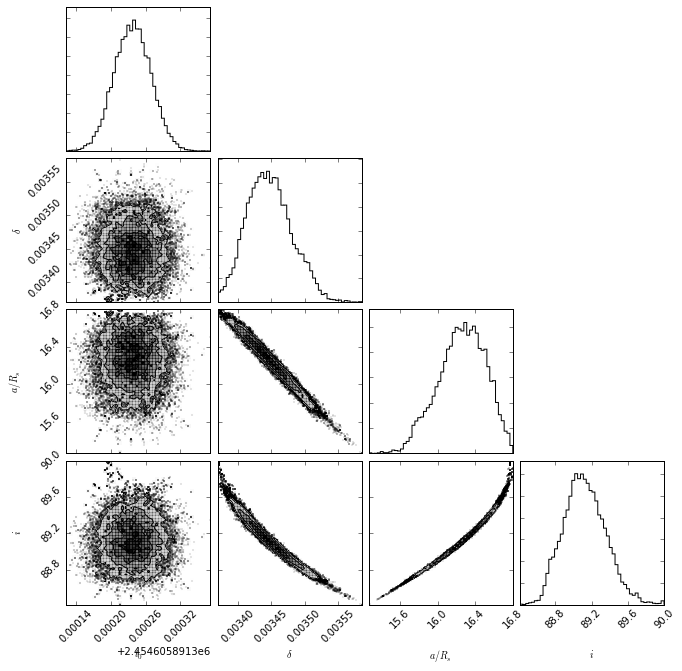

In [23]:
print("accept frac = {}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples)

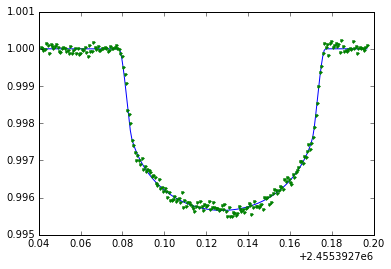

[2454605.89155, 0.00343158069508, 16.4121532927, 89.2352005102]


In [24]:
from cleanfit import generate_model_lc_short

plot_these = samples[-1,:]
this_part = np.arange(len(transit_lc.times)) < 0.3*len(transit_lc.times)
plt.plot(transit_lc.times.jd[this_part], generate_model_lc_short(transit_lc.times.jd, *plot_these)[this_part])
plt.plot(transit_lc.times.jd[this_part], transit_lc.fluxes[this_part],'.')
plt.show()
print("[{}]".format(", ".join(map(str, samples[-1,:]))))
